In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from datetime import datetime
import warnings

# Gradient Boosting
import xgboost as xgb
import lightgbm as lgb

# Sklearn
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score
)

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

✓ All libraries imported successfully
XGBoost version: 3.2.0
LightGBM version: 4.6.0


In [2]:
print("="*60)
print("LOADING DATA & BASELINE RESULTS")
print("="*60)

# Load processed data
train_df = pd.read_csv('../data/processed/train.csv')
val_df = pd.read_csv('../data/processed/validation.csv')
test_df = pd.read_csv('../data/processed/test.csv')

# Load feature info
with open('../data/processed/feature_info.json', 'r') as f:
    feature_info = json.load(f)

feature_columns = feature_info['feature_columns']

# Prepare splits
X_train = train_df[feature_columns]
y_train = train_df['isMalicious']

X_val = val_df[feature_columns]
y_val = val_df['isMalicious']

X_test = test_df[feature_columns]
y_test = test_df['isMalicious']

print(f"✓ Training set:   {len(X_train):,} samples")
print(f"✓ Validation set: {len(X_val):,} samples")
print(f"✓ Test set:       {len(X_test):,} samples")
print(f"✓ Features:       {len(feature_columns)}")

# Load baseline results for comparison
with open('../models/baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

print("\n" + "="*60)
print("BASELINE TO BEAT")
print("="*60)
print(f"Logistic Regression - Validation Performance:")
lr_val = baseline_results['logistic_regression']['validation']
print(f"  F1-Score: {lr_val['f1']:.4f}")
print(f"  ROC-AUC:  {lr_val['roc_auc']:.4f}")
print(f"  Recall:   {lr_val['recall']:.4f}")
print(f"  Precision: {lr_val['precision']:.4f}")

LOADING DATA & BASELINE RESULTS
✓ Training set:   27,478 samples
✓ Validation set: 5,870 samples
✓ Test set:       5,886 samples
✓ Features:       21

BASELINE TO BEAT
Logistic Regression - Validation Performance:
  F1-Score: 0.9504
  ROC-AUC:  0.9839
  Recall:   0.9247
  Precision: 0.9777


In [3]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name, dataset_name="Validation"):
    """Comprehensive model evaluation with security-focused metrics"""
    print(f"\n{'='*60}")
    print(f"{model_name} - {dataset_name} Set Performance")
    print(f"{'='*60}")
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print(f"\n📊 CLASSIFICATION METRICS:")
    print(f"   Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision:  {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Recall:     {recall:.4f} ({recall*100:.2f}%)")
    print(f"   F1-Score:   {f1:.4f}")
    print(f"   ROC-AUC:    {roc_auc:.4f}")
    
    print(f"\n🎯 CONFUSION MATRIX:")
    print(f"   TN: {tn:,} | FP: {fp:,}")
    print(f"   FN: {fn:,} | TP: {tp:,}")
    
    print(f"\n⚠️  ERROR RATES:")
    print(f"   FPR: {fpr:.4f} | FNR: {fnr:.4f} {'⚠️ HIGH' if fnr > 0.05 else '✓'}")
    
    # Comparison to baseline
    if model_name != "Logistic Regression + TF-IDF":
        lr_f1 = lr_val['f1']
        lr_auc = lr_val['roc_auc']
        f1_diff = f1 - lr_f1
        auc_diff = roc_auc - lr_auc
        
        print(f"\n📈 vs BASELINE (Logistic Regression):")
        print(f"   F1:  {f1_diff:+.4f} {'✓ BETTER' if f1_diff > 0 else '✗ WORSE'}")
        print(f"   AUC: {auc_diff:+.4f} {'✓ BETTER' if auc_diff > 0 else '✗ WORSE'}")
    
    return {
        'model_name': model_name,
        'dataset': dataset_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
        'fpr': fpr, 'fnr': fnr
    }

def plot_confusion_matrix(y_true, y_pred, model_name, dataset_name="Validation"):
    """Plot confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malicious'],
                yticklabels=['Benign', 'Malicious'])
    plt.title(f'{model_name} - Confusion Matrix ({dataset_name})', 
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    return plt.gcf()

print("✓ Evaluation functions loaded")

✓ Evaluation functions loaded


In [4]:
print("\n" + "="*60)
print("MODEL 1: XGBoost Classifier")
print("="*60)

# XGBoost with initial parameters
print("\n1. Training XGBoost with default parameters...")

xgb_model = xgb.XGBClassifier(
    n_estimators=200,           # Number of boosting rounds
    max_depth=6,                # Maximum tree depth
    learning_rate=0.1,          # Step size shrinkage
    subsample=0.8,              # Subsample ratio of training instances
    colsample_bytree=0.8,       # Subsample ratio of features
    gamma=0,                    # Minimum loss reduction for split
    min_child_weight=1,         # Minimum sum of instance weight in child
    scale_pos_weight=1,         # Balance of positive/negative weights (1 since balanced)
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=20,   # Stop if no improvement for 20 rounds
    n_jobs=-1,
    verbosity=1
)

# Train with evaluation set for early stopping
eval_set = [(X_train, y_train), (X_val, y_val)]

xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

print(f"✓ Training complete")
print(f"  Best iteration: {xgb_model.best_iteration}")
print(f"  Best score: {xgb_model.best_score:.4f}")

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]

y_val_pred_xgb = xgb_model.predict(X_val)
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

print("✓ Predictions complete")


MODEL 1: XGBoost Classifier

1. Training XGBoost with default parameters...
✓ Training complete
  Best iteration: 109
  Best score: 0.1823
✓ Predictions complete


In [5]:
# Evaluate
train_metrics_xgb = evaluate_model(
    y_train, y_train_pred_xgb, y_train_proba_xgb,
    "XGBoost", "Training"
)

val_metrics_xgb = evaluate_model(
    y_val, y_val_pred_xgb, y_val_proba_xgb,
    "XGBoost", "Validation"
)


XGBoost - Training Set Performance

📊 CLASSIFICATION METRICS:
   Accuracy:   0.9452 (94.52%)
   Precision:  0.9924 (99.24%)
   Recall:     0.8973 (89.73%)
   F1-Score:   0.9424
   ROC-AUC:    0.9797

🎯 CONFUSION MATRIX:
   TN: 13,644 | FP: 95
   FN: 1,411 | TP: 12,328

⚠️  ERROR RATES:
   FPR: 0.0069 | FNR: 0.1027 ⚠️ HIGH

📈 vs BASELINE (Logistic Regression):
   F1:  -0.0080 ✗ WORSE
   AUC: -0.0042 ✗ WORSE

XGBoost - Validation Set Performance

📊 CLASSIFICATION METRICS:
   Accuracy:   0.9383 (93.83%)
   Precision:  0.9849 (98.49%)
   Recall:     0.8903 (89.03%)
   F1-Score:   0.9352
   ROC-AUC:    0.9661

🎯 CONFUSION MATRIX:
   TN: 2,895 | FP: 40
   FN: 322 | TP: 2,613

⚠️  ERROR RATES:
   FPR: 0.0136 | FNR: 0.1097 ⚠️ HIGH

📈 vs BASELINE (Logistic Regression):
   F1:  -0.0152 ✗ WORSE
   AUC: -0.0178 ✗ WORSE


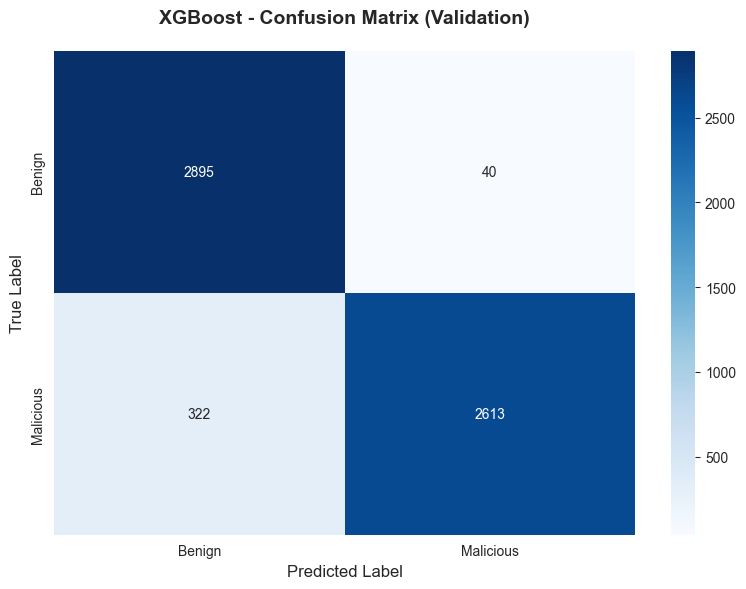

In [6]:
# Visualize confusion matrix
fig = plot_confusion_matrix(y_val, y_val_pred_xgb, "XGBoost", "Validation")
plt.savefig('../notebooks/xgb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


XGBoost FEATURE IMPORTANCE


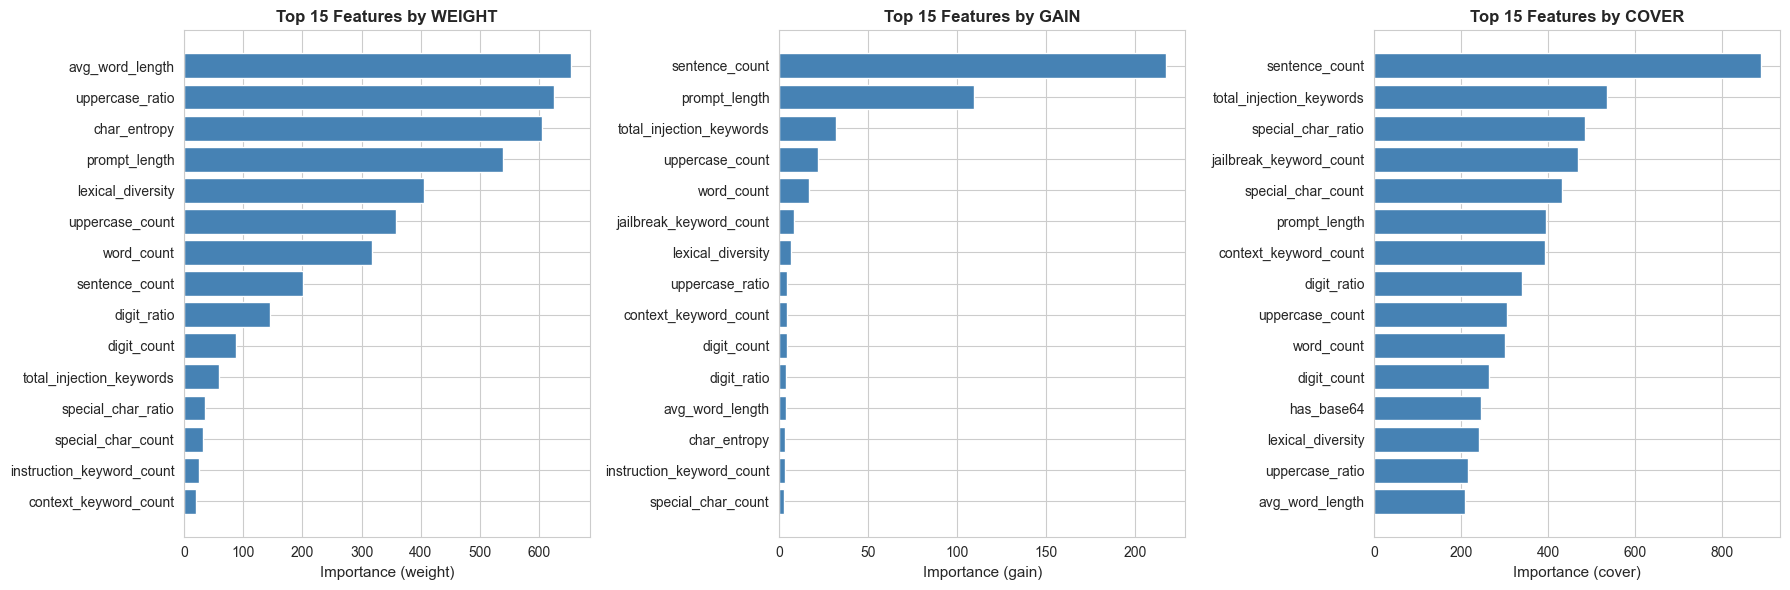


Top 10 features by GAIN (most useful for prediction):
                 feature       gain
          sentence_count 217.398285
           prompt_length 109.749397
total_injection_keywords  31.627602
         uppercase_count  21.864101
              word_count  16.766888
 jailbreak_keyword_count   8.467945
       lexical_diversity   6.407754
         uppercase_ratio   4.497161
   context_keyword_count   4.414609
             digit_count   4.035424


In [7]:
# Feature Importance Analysis
print("\n" + "="*60)
print("XGBoost FEATURE IMPORTANCE")
print("="*60)

# XGBoost provides multiple importance types
importance_types = ['weight', 'gain', 'cover']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, imp_type in enumerate(importance_types):
    importance_dict = xgb_model.get_booster().get_score(importance_type=imp_type)
    
    # Convert to dataframe
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values('importance', ascending=False).head(15)
    
    # Plot
    axes[idx].barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
    axes[idx].set_yticks(range(len(importance_df)))
    axes[idx].set_yticklabels(importance_df['feature'])
    axes[idx].set_xlabel(f'Importance ({imp_type})', fontsize=11)
    axes[idx].set_title(f'Top 15 Features by {imp_type.upper()}', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig('../notebooks/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top features by gain (most important type)
print("\nTop 10 features by GAIN (most useful for prediction):")
importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
importance_gain_df = pd.DataFrame({
    'feature': list(importance_gain.keys()),
    'gain': list(importance_gain.values())
}).sort_values('gain', ascending=False)

print(importance_gain_df.head(10).to_string(index=False))

In [8]:
print("\n" + "="*60)
print("MODEL 2: LightGBM Classifier")
print("="*60)

print("\n1. Training LightGBM with default parameters...")

lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,              # LightGBM-specific: max number of leaves
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,       # Minimum data in leaf
    reg_alpha=0.0,              # L1 regularization
    reg_lambda=0.0,             # L2 regularization
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
)

print(f"✓ Training complete")
print(f"  Best iteration: {lgb_model.best_iteration_}")
print(f"  Best score: {lgb_model.best_score_['valid_0']['auc']:.4f}")

# Predictions
y_train_pred_lgb = lgb_model.predict(X_train)
y_train_proba_lgb = lgb_model.predict_proba(X_train)[:, 1]

y_val_pred_lgb = lgb_model.predict(X_val)
y_val_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]

print("✓ Predictions complete")


MODEL 2: LightGBM Classifier

1. Training LightGBM with default parameters...
✓ Training complete
  Best iteration: 82
  Best score: 0.9667
✓ Predictions complete


In [10]:
# Evaluate
train_metrics_lgb = evaluate_model(
    y_train, y_train_pred_lgb, y_train_proba_lgb,
    "LightGBM", "Training"
)

val_metrics_lgb = evaluate_model(
    y_val, y_val_pred_lgb, y_val_proba_lgb,
    "LightGBM", "Validation"
)


LightGBM - Training Set Performance

📊 CLASSIFICATION METRICS:
   Accuracy:   0.9436 (94.36%)
   Precision:  0.9926 (99.26%)
   Recall:     0.8939 (89.39%)
   F1-Score:   0.9407
   ROC-AUC:    0.9758

🎯 CONFUSION MATRIX:
   TN: 13,648 | FP: 91
   FN: 1,458 | TP: 12,281

⚠️  ERROR RATES:
   FPR: 0.0066 | FNR: 0.1061 ⚠️ HIGH

📈 vs BASELINE (Logistic Regression):
   F1:  -0.0098 ✗ WORSE
   AUC: -0.0082 ✗ WORSE

LightGBM - Validation Set Performance

📊 CLASSIFICATION METRICS:
   Accuracy:   0.9365 (93.65%)
   Precision:  0.9834 (98.34%)
   Recall:     0.8879 (88.79%)
   F1-Score:   0.9332
   ROC-AUC:    0.9667

🎯 CONFUSION MATRIX:
   TN: 2,891 | FP: 44
   FN: 329 | TP: 2,606

⚠️  ERROR RATES:
   FPR: 0.0150 | FNR: 0.1121 ⚠️ HIGH

📈 vs BASELINE (Logistic Regression):
   F1:  -0.0172 ✗ WORSE
   AUC: -0.0173 ✗ WORSE


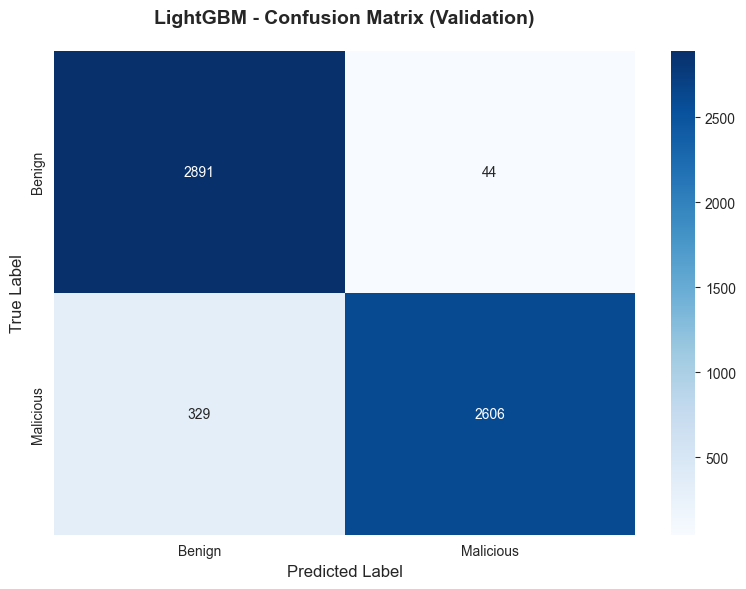

In [11]:
# Visualize
fig = plot_confusion_matrix(y_val, y_val_pred_lgb, "LightGBM", "Validation")
plt.savefig('../notebooks/lgb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


LightGBM FEATURE IMPORTANCE

Top 10 most important features:
                 feature  importance
         avg_word_length         381
           prompt_length         318
         uppercase_count         312
            char_entropy         284
         uppercase_ratio         266
              word_count         233
       lexical_diversity         193
          sentence_count         139
             digit_ratio          67
total_injection_keywords          49


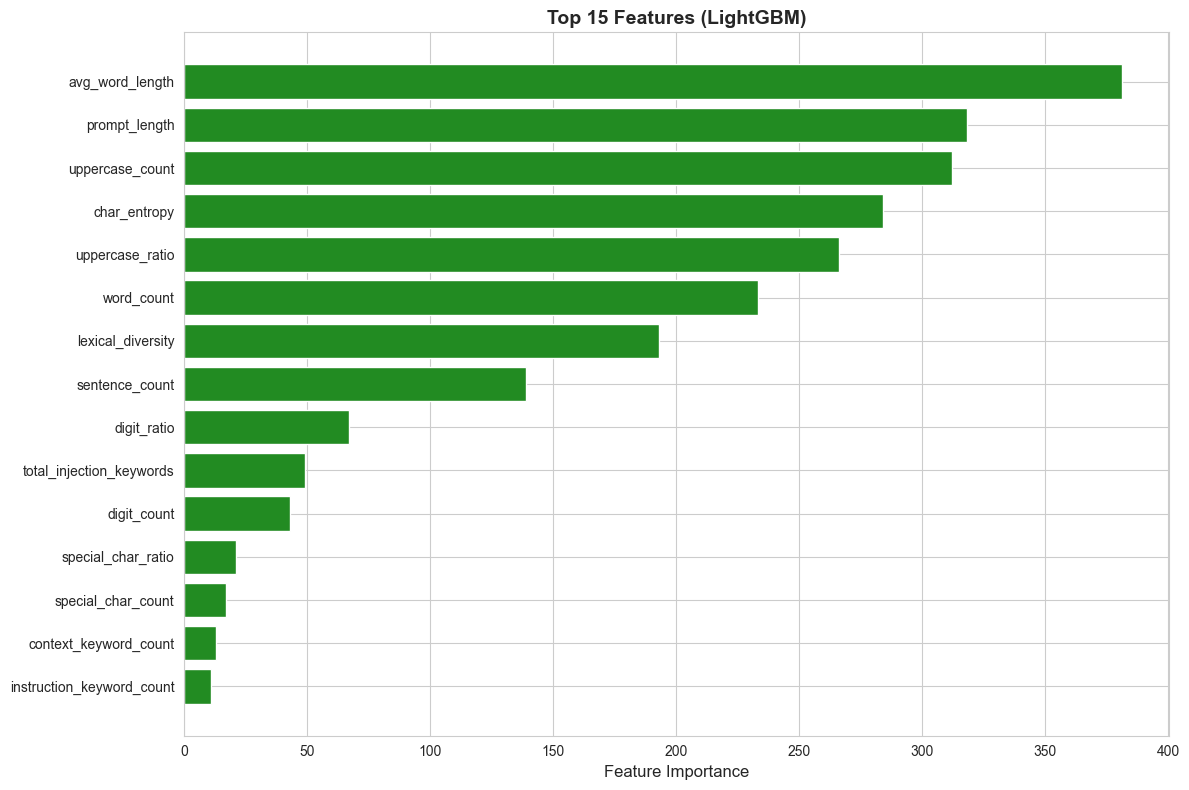

In [12]:
# Feature Importance
print("\n" + "="*60)
print("LightGBM FEATURE IMPORTANCE")
print("="*60)

lgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(lgb_importance.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_15 = lgb_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='forestgreen')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Features (LightGBM)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../notebooks/lgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Determine which model to tune (whichever has higher F1)
if val_metrics_xgb['f1'] >= val_metrics_lgb['f1']:
    print("\nTuning XGBoost (better baseline performance)")
    tune_model = 'xgb'
    base_f1 = val_metrics_xgb['f1']
else:
    print("\nTuning LightGBM (better baseline performance)")
    tune_model = 'lgb'
    base_f1 = val_metrics_lgb['f1']

print(f"Baseline F1 to beat: {base_f1:.4f}")


HYPERPARAMETER TUNING

Tuning XGBoost (better baseline performance)
Baseline F1 to beat: 0.9352


In [14]:
# Grid search for XGBoost
if tune_model == 'xgb':
    print("\nPerforming GridSearchCV for XGBoost...")
    
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.15],
        'n_estimators': [150, 200, 250],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
    }
    
    # Smaller grid for speed
    param_grid_small = {
        'max_depth': [5, 7],
        'learning_rate': [0.08, 0.12],
        'n_estimators': [180, 220],
    }
    
    xgb_tuned = xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    # Use 3-fold CV to save time
    grid_search = GridSearchCV(
        xgb_tuned,
        param_grid_small,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\n✓ Grid search complete")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV F1 score: {grid_search.best_score_:.4f}")
    
    # Train final model with best params
    best_model = grid_search.best_estimator_
    
    y_val_pred_tuned = best_model.predict(X_val)
    y_val_proba_tuned = best_model.predict_proba(X_val)[:, 1]
    
    val_metrics_tuned = evaluate_model(
        y_val, y_val_pred_tuned, y_val_proba_tuned,
        "XGBoost (Tuned)", "Validation"
    )

# Grid search for LightGBM
else:
    print("\nPerforming GridSearchCV for LightGBM...")
    
    param_grid_small = {
        'max_depth': [5, 7],
        'learning_rate': [0.08, 0.12],
        'n_estimators': [180, 220],
        'num_leaves': [25, 35],
    }
    
    lgb_tuned = lgb.LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    grid_search = GridSearchCV(
        lgb_tuned,
        param_grid_small,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\n✓ Grid search complete")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV F1 score: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
    
    y_val_pred_tuned = best_model.predict(X_val)
    y_val_proba_tuned = best_model.predict_proba(X_val)[:, 1]
    
    val_metrics_tuned = evaluate_model(
        y_val, y_val_pred_tuned, y_val_proba_tuned,
        "LightGBM (Tuned)", "Validation"
    )


Performing GridSearchCV for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✓ Grid search complete
Best parameters: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 220}
Best CV F1 score: 0.9364

XGBoost (Tuned) - Validation Set Performance

📊 CLASSIFICATION METRICS:
   Accuracy:   0.9382 (93.82%)
   Precision:  0.9853 (98.53%)
   Recall:     0.8896 (88.96%)
   F1-Score:   0.9350
   ROC-AUC:    0.9660

🎯 CONFUSION MATRIX:
   TN: 2,896 | FP: 39
   FN: 324 | TP: 2,611

⚠️  ERROR RATES:
   FPR: 0.0133 | FNR: 0.1104 ⚠️ HIGH

📈 vs BASELINE (Logistic Regression):
   F1:  -0.0154 ✗ WORSE
   AUC: -0.0180 ✗ WORSE


In [15]:
print("\n" + "="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)

# Gather all validation metrics
all_metrics = pd.DataFrame([
    baseline_results['logistic_regression']['validation'],
    baseline_results['random_forest']['validation'],
    val_metrics_xgb,
    val_metrics_lgb,
    val_metrics_tuned
])

# Select key columns
comparison_df = all_metrics[['model_name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'fnr']]

print("\n📊 ALL MODELS - Validation Performance:")
print(comparison_df.to_string(index=False))

# Highlight best performers
print("\n🏆 BEST PERFORMERS:")
print(f"   Highest F1:      {comparison_df.loc[comparison_df['f1'].idxmax(), 'model_name']:<30} (F1={comparison_df['f1'].max():.4f})")
print(f"   Highest AUC:     {comparison_df.loc[comparison_df['roc_auc'].idxmax(), 'model_name']:<30} (AUC={comparison_df['roc_auc'].max():.4f})")
print(f"   Highest Recall:  {comparison_df.loc[comparison_df['recall'].idxmax(), 'model_name']:<30} (Recall={comparison_df['recall'].max():.4f})")
print(f"   Lowest FNR:      {comparison_df.loc[comparison_df['fnr'].idxmin(), 'model_name']:<30} (FNR={comparison_df['fnr'].min():.4f})")


COMPREHENSIVE MODEL COMPARISON

📊 ALL MODELS - Validation Performance:
                  model_name  accuracy  precision   recall       f1  roc_auc      fnr
Logistic Regression + TF-IDF  0.951789   0.977666 0.924702 0.950447 0.983949 0.075298
    Random Forest + Features  0.937308   0.984522 0.888586 0.934097 0.965365 0.111414
                     XGBoost  0.938330   0.984923 0.890290 0.935218 0.966106 0.109710
                    LightGBM  0.936457   0.983396 0.887905 0.933214 0.966656 0.112095
             XGBoost (Tuned)  0.938160   0.985283 0.889608 0.935004 0.965973 0.110392

🏆 BEST PERFORMERS:
   Highest F1:      Logistic Regression + TF-IDF   (F1=0.9504)
   Highest AUC:     Logistic Regression + TF-IDF   (AUC=0.9839)
   Highest Recall:  Logistic Regression + TF-IDF   (Recall=0.9247)
   Lowest FNR:      Logistic Regression + TF-IDF   (FNR=0.0753)


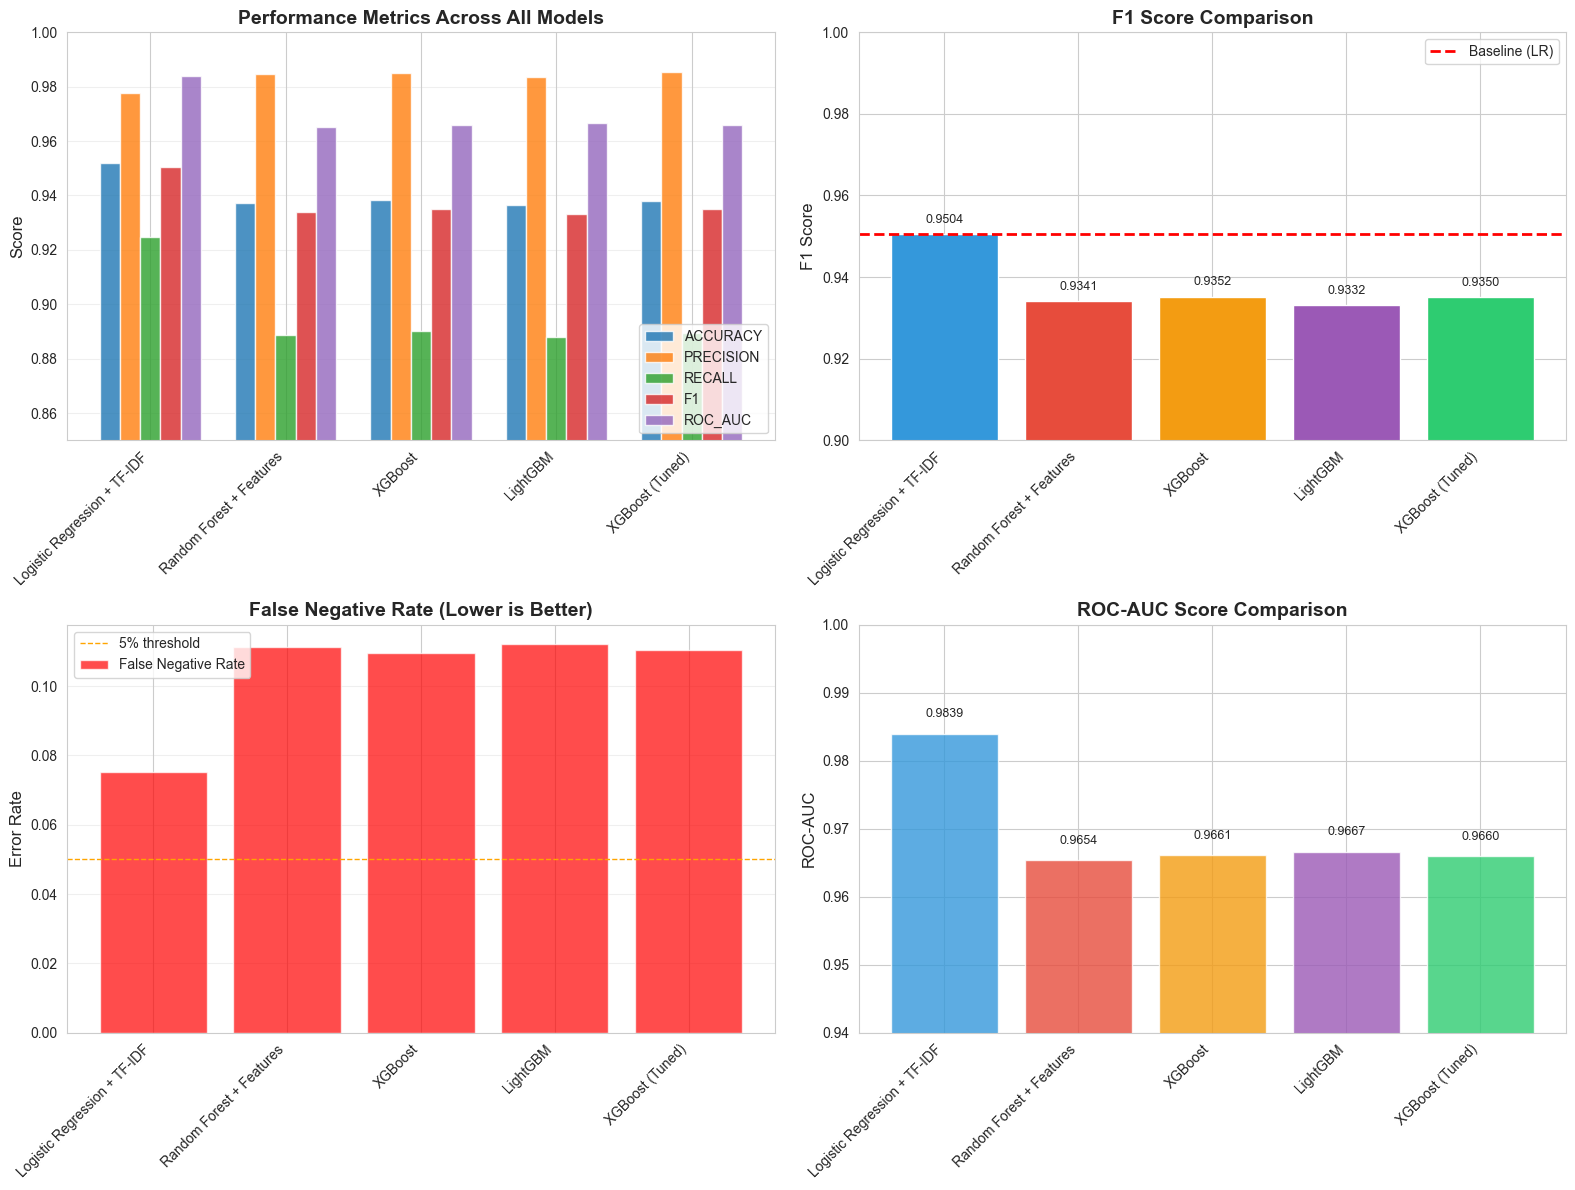

In [16]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Metrics comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(comparison_df))
width = 0.15

for i, metric in enumerate(metrics):
    axes[0, 0].bar(x + i*width, comparison_df[metric], width, 
                   label=metric.upper(), alpha=0.8)

axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Performance Metrics Across All Models', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x + width * 2)
axes[0, 0].set_xticklabels(comparison_df['model_name'], rotation=45, ha='right')
axes[0, 0].legend(loc='lower right')
axes[0, 0].set_ylim([0.85, 1.0])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. F1 Score comparison
colors = ['#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#2ecc71']
axes[0, 1].bar(range(len(comparison_df)), comparison_df['f1'], color=colors)
axes[0, 1].set_ylabel('F1 Score', fontsize=12)
axes[0, 1].set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(range(len(comparison_df)))
axes[0, 1].set_xticklabels(comparison_df['model_name'], rotation=45, ha='right')
axes[0, 1].axhline(y=lr_val['f1'], color='red', linestyle='--', linewidth=2, label='Baseline (LR)')
axes[0, 1].legend()
axes[0, 1].set_ylim([0.90, 1.0])

# Add value labels
for i, v in enumerate(comparison_df['f1']):
    axes[0, 1].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# 3. Error rates
axes[1, 0].bar(range(len(comparison_df)), comparison_df['fnr'], 
               color='red', alpha=0.7, label='False Negative Rate')
axes[1, 0].set_ylabel('Error Rate', fontsize=12)
axes[1, 0].set_title('False Negative Rate (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(len(comparison_df)))
axes[1, 0].set_xticklabels(comparison_df['model_name'], rotation=45, ha='right')
axes[1, 0].axhline(y=0.05, color='orange', linestyle='--', linewidth=1, label='5% threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. ROC-AUC comparison
axes[1, 1].bar(range(len(comparison_df)), comparison_df['roc_auc'], color=colors, alpha=0.8)
axes[1, 1].set_ylabel('ROC-AUC', fontsize=12)
axes[1, 1].set_title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(range(len(comparison_df)))
axes[1, 1].set_xticklabels(comparison_df['model_name'], rotation=45, ha='right')
axes[1, 1].set_ylim([0.94, 1.0])

# Add value labels
for i, v in enumerate(comparison_df['roc_auc']):
    axes[1, 1].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../notebooks/all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
print("\n" + "="*60)
print("FINAL MODEL SELECTION")
print("="*60)

# Select best model based on F1 score (balanced metric)
best_idx = comparison_df['f1'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'model_name']
best_f1 = comparison_df.loc[best_idx, 'f1']
best_auc = comparison_df.loc[best_idx, 'roc_auc']

print(f"\n🏆 WINNER: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   ROC-AUC:  {best_auc:.4f}")
print(f"   Recall:   {comparison_df.loc[best_idx, 'recall']:.4f}")
print(f"   FNR:      {comparison_df.loc[best_idx, 'fnr']:.4f}")

# Determine which model object to save
if 'XGBoost (Tuned)' in best_model_name:
    final_model = best_model
    model_type = 'xgboost_tuned'
elif 'LightGBM (Tuned)' in best_model_name:
    final_model = best_model
    model_type = 'lightgbm_tuned'
elif 'XGBoost' in best_model_name:
    final_model = xgb_model
    model_type = 'xgboost'
elif 'LightGBM' in best_model_name:
    final_model = lgb_model
    model_type = 'lightgbm'
else:
    print("\nNote: Best model is from baseline (Session 3)")
    print("No new model to save.")
    final_model = None
    model_type = None

# Save if it's a gradient boosting model
if final_model is not None:
    model_path = f'../models/{model_type}_best.pkl'
    joblib.dump(final_model, model_path)
    print(f"\n✓ Saved best model: {model_path}")

# Save all results
session4_results = {
    'timestamp': datetime.now().isoformat(),
    'xgboost': {
        'validation': val_metrics_xgb
    },
    'lightgbm': {
        'validation': val_metrics_lgb
    },
    'tuned_model': {
        'validation': val_metrics_tuned,
        'model_type': tune_model,
        'best_params': grid_search.best_params_ if 'grid_search' in locals() else None
    },
    'best_overall': {
        'model_name': best_model_name,
        'metrics': comparison_df.loc[best_idx].to_dict()
    }
}

with open('../models/session4_results.json', 'w') as f:
    json.dump(session4_results, f, indent=2)

print("✓ Saved results: ../models/session4_results.json")


FINAL MODEL SELECTION

🏆 WINNER: Logistic Regression + TF-IDF
   F1-Score: 0.9504
   ROC-AUC:  0.9839
   Recall:   0.9247
   FNR:      0.0753

Note: Best model is from baseline (Session 3)
No new model to save.
✓ Saved results: ../models/session4_results.json
